# Exercise 3: Shape Reconstruction

**Submission Deadline**: 18.12.2024, 23:55

We will take a look at two major approaches for 3D shape reconstruction in this last exercise.

Note that training reconstruction methods generally takes relatively long, even for simple shape completion. Training the generalization will take a few hours. **Thus, please make sure to start training well before the submission deadline.**

## 3.0. Running this notebook
We recommend running this notebook on a CUDA compatible local gpu. You can also run training on cpu, it will just take longer.

You have three options for running this exercise on a GPU, choose one of them and start the exercise below in section "Imports":
1. Locally on your own GPU
2. On our dedicated compute cluster
3. On Google Colab

We describe every option in more detail below:

---

### (a) Local Execution

If you run this notebook locally, you have to first install the python dependiencies again. They are the same as for exercise 1 so you can re-use the environment you used last time. If you use [poetry](https://python-poetry.org), you can also simply re-install everything (`poetry install`) and then run this notebook via `poetry run jupyter notebook`.

In case you are working with a RTX 3000-series GPU, you need to install a patched version of pytorch:

In [ ]:
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

### (b) Compute Cluster

We provide access to a small compute cluster for the exercises and projects, consisting of a login node and 4 compute nodes with one dedicated RTX 3090 GPU each.
Please send us a short email with your name and preferred username so we can add you as a user.

We uploaded a PDF to Moodle with detailed information on how to access and use the cluster.

Since the cluster contains RTX 3000-series GPUs, you will need to install a patched version of pytorch:

In [ ]:
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

### (c) Google Colab

If you don't have access to a GPU and don't want to use our cluster, you can also use Google Colab. However, we experienced the issue that inline visualization of shapes or inline images didn't work on colab, so just keep that in mind.
What you can also do is only train networks on colab, download the checkpoint, and visualize inference locally.

In case you're using Google Colab, you can upload the exercise folder (containing `exercise_2.ipynb`, directory `exercise_2` and the file `requirements.txt`) as `3d-machine-learning` to google drive (make sure you don't upload extracted datasets files).
Additionally you'd need to open the notebook `exercise_2.ipynb` in Colab using `File > Open Notebook > Upload`.

Next you'll need to run these two cells for setting up the environment. Before you do that make sure your instance has a GPU.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# We assume you uploaded the exercise folder in root Google Drive folder

!cp -r /content/drive/MyDrive/3d-ml-ex3 3d-machine-learning/
os.chdir('/content/3d-machine-learning/')
print('Installing requirements')
%pip install -r requirements.txt

# Make sure you restart runtime when directed by Colab

Mounted at /content/drive
Installing requirements
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 945.1/945.1 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Run this cell after restarting your colab runtime

In [2]:
import os
import sys
import torch
os.chdir('/content/3d-machine-learning/')
sys.path.insert(1, "/content/3d-machine-learning/")
print('CUDA availability:', torch.cuda.is_available())

CUDA availability: True


### Imports

The following imports should work regardless of whether you are using Colab or local execution.

In [3]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import k3d
import trimesh
import torch
import skimage
from PIL import Image

Use the next cell to test whether a GPU was detected by pytorch.

In [4]:
torch.cuda.is_available()

True

## 3.1 DeepSDF


Here, we will take a look at 3D-reconstruction using [DeepSDF](https://arxiv.org/abs/1901.05103). We recommend reading the paper before attempting the exercise.

DeepSDF is an auto-decoder based approach that learns a continuous SDF representation for a class of shapes. Once trained, it can be used for shape representation, interpolation and shape completion. We'll look at each of these
applications.

<img src="exercise_3/images/deepsdf_teaser.png" alt="deepsdf_teaser" style="width: 800px;"/>

During training, the autodecoder optimizes both the network parameters and the latent codes representing each of the training shapes. Once trained, to reconstruct a shape given its SDF observations, a latent code is
optimized keeping the network parameters fixed, such that the optimized latent code gives the lowest error with observed SDF values.

An advantage that implicit representations have over voxel/grid based approaches is that they are not tied to a particular grid resolution, and can be evaluated at any resolution once trained.

Similar to previous exercise, we'll first download the processed dataset, look at the implementation of the dataset, the model and the trainer, try out overfitting and generalization over the entire dataset, and finally inference on unseen samples.

### (a) Downloading the data

Whereas volumetric models output entire 3d shape representations, implicit models like DeepSDF work on per point basis. The network takes in a 3D-coordinate (and additionally the latent vector) and outputs the SDF value at the queried point. To train such a model,
we therefore need, for each of the training shapes, a bunch of points with their corresponding SDF values for supervision. Points are sampled more aggressively near the surface of the object as we want to capture a more detailed SDF near the surface. For those curious,
data preparation is decribed in more detail in section 5 of the paper.

We'll be using the ShapeNet Sofa class for the experiments in this exercise. We've already prepared this data, so that you don't need to deal with the preprocessing. For each shape, the following files are provided:
- `mesh.obj` representing the mesh representation of the shape
- `sdf.npz` file containing large number of points sampled on and around the mesh and their sdf values; contains numpy arrays under keys "pos" and "neg", containing points with positive and negative sdf values respectively

```
# contents of exercise_3/data/sdf_sofas
1faa4c299b93a3e5593ebeeedbff73b/                    # shape 0
    ├── mesh.obj                                    # shape 0 mesh
    ├── sdf.npz                                     # shape 0 sdf
    ├── surface.obj                                 # shape 0 surface
1fde48d83065ef5877a929f61fea4d0/                    # shape 1
1fe1411b6c8097acf008d8a3590fb522/                   # shape 2
:
```
Download and extract the data with the code cell below.

In [ ]:
print('Downloading ...')
# File sizes: ~10GB
!wget https://www.dropbox.com/s/4k5pw126nzus8ef/sdf_sofas.zip\?dl\=0 -O exercise_3/data/sdf_sofas.zip -P exercise_3/data

print('Extracting ...')
!unzip -q exercise_3/data/sdf_sofas.zip -d exercise_3/data
!rm exercise_3/data/sdf_sofas.zip

print('Done.')

### (b) Dataset

We provide a partial implementation of the dataset in `exercise_3/data/shape_implicit.py`.
Your task is to complete the `#TODOs` so that the dataset works as specified by the docstrings.

Once done, you can try running the following code blocks as sanity checks.

In [ ]:
from exercise_3.data.shape_implicit import ShapeImplicit

num_points_to_samples = 40000
train_dataset = ShapeImplicit(num_points_to_samples, "train")
val_dataset = ShapeImplicit(num_points_to_samples, "val")
overfit_dataset = ShapeImplicit(num_points_to_samples, "overfit")

# Get length, which is a call to __len__ function
print(f'Length of train set: {len(train_dataset)}')  # expected output: 1226
# Get length, which is a call to __len__ function
print(f'Length of val set: {len(val_dataset)}')  # expected output: 137
# Get length, which is a call to __len__ function
print(f'Length of overfit set: {len(overfit_dataset)}')  # expected output: 1

Let's take a look at the points sampled for a particular shape.

In [ ]:
from exercise_3.util.visualization import visualize_mesh, visualize_pointcloud

shape_id = train_dataset[0]['name']
points = train_dataset[0]['points']
sdf = train_dataset[0]['sdf']

# sampled points inside the shape
inside_points = points[sdf[:, 0] < 0, :].numpy()

# sampled points outside the shape
outside_points = points[sdf[:, 0] > 0, :].numpy()

In [ ]:
mesh = ShapeImplicit.get_mesh(shape_id)
print('Mesh')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

In [ ]:
print('Sampled points with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)

In [ ]:
print('Sampled points with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

You'll notice that more points are sampled close to the surface rather than away from the surface.

### (c) Model

The DeepSDF auto-decoder architecture is visualized below:

<img src="exercise_3/images/deepsdf_architecture.png" alt="deepsdf_arch" style="width: 640px;"/>

Things to note:

- The network takes in the latent code for a shape concatenated with the query 3d coordinate, making up a 259 length vector (assuming latent code length is 256).
- The network consist of a sequence of weight-normed linear layers, each followed by a ReLU and a dropout. For weight norming a layer, check out `torch.nn.utils.weight_norm`. Each of these linear layers outputs a 512 dimensional vector, except the 4th layer which outputs a 253 dimensional vector.
- The output of the 4th layer is concatenated with the input, making the input to the 5th layer a 512 dimensional vector.
- The final layer is a simple linear layer without any norm, dropout or non-linearity, with a single dimensional output representing the SDF value.

Implement this architecture in file `exercise_3/model/deepsdf.py`.

Here are some basic sanity tests once you're done with your implementation.

In [ ]:
from exercise_3.model.deepsdf import DeepSDFDecoder
from exercise_3.util.model import summarize_model

deepsdf = DeepSDFDecoder(latent_size=256)
print(summarize_model(deepsdf))

# input to the network is a concatenation of point coordinates (3) and the latent code (256 in this example);
# here we use a batch of 4096 points
input_tensor = torch.randn(4096, 3 + 256)
predictions = deepsdf(input_tensor)

print('\nOutput tensor shape: ', predictions.shape)  # expected output: 4096, 1

num_trainable_params = sum(p.numel() for p in deepsdf.parameters() if p.requires_grad) / 1e6
print(f'\nNumber of traininable params: {num_trainable_params:.2f}M')  # expected output: ~1.8M

### (d) Training script and overfitting to a single shape

Fill in the train script in `exercise_3/training/train_deepsdf.py`, and verify that your training work by overfitting to a few samples below.

In [ ]:
from exercise_3.training import train_deepsdf

overfit_config = {
    'experiment_name': '3_1_deepsdf_overfit',
    'device': 'cuda:0',  # change this to cpu if you do not have a GPU
    'is_overfit': True,
    'num_sample_points': 4096,
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 2000,
    'print_every_n': 50,
    'visualize_every_n': 250,
}

train_deepsdf.main(overfit_config)  # expected loss around 0.0062

Let's visualize the overfitted shape reconstruction to check if it looks reasonable.

In [ ]:
# Load and visualize GT mesh of the overfit sample
gt_mesh = ShapeImplicit.get_mesh('7e728818848f191bee7d178666aae23d')
print('GT')
visualize_mesh(gt_mesh.vertices, gt_mesh.faces, flip_axes=True)

# Load and visualize reconstructed overfit sample; it's okay if they don't look visually exact, since we don't run
# the training too long and have a learning rate decay while training
mesh_path = "exercise_3/runs/3_1_deepsdf_overfit/meshes/01999_000.obj"
overfit_output = trimesh.load(mesh_path)
print('Overfit')
visualize_mesh(overfit_output.vertices, overfit_output.faces, flip_axes=True)

### (e) Training over entire train set

Once overfitting works, we can train on the entire train set.

Note: This training will take a few hours on a GPU (took ~3 hrs for 500 epochs on our 2080Ti, which already gave decent results). Please make sure to start training early enough before the submission deadline.

In [ ]:
from exercise_3.training import train_deepsdf

generalization_config = {
    'experiment_name': '3_1_deepsdf_generalization',
    'device': 'cuda:0',  # run this on a gpu for a reasonable training time
    'is_overfit': False,
    'num_sample_points': 4096, # you can adjust this such that the model fits on your gpu
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 2000,  # not necessary to run for 2000 epochs if you're short on time, at 500 epochs you should start to see reasonable results
    'print_every_n': 50,
    'visualize_every_n': 5000,
}

train_deepsdf.main(generalization_config)

### (f) Inference using the trained model on observed SDF values

Fill in the inference script `exercise_3/inference/infer_deepsdf.py`. Note that it's not simply a forward pass, but an optimization of the latent code such that we have lowest error on observed SDF values.

In [ ]:
from exercise_3.inference.infer_deepsdf import InferenceHandlerDeepSDF

device = torch.device('cuda:0')  # change this to cpu if you're not using a gpu

inference_handler = InferenceHandlerDeepSDF(256, "exercise_3/runs/3_1_deepsdf_generalization", device)

First, we try inference on a shape from validation set, for which we have a complete observation of sdf values. This is an easier problem as compared to shape completion,
since we have all the information already in the input.

Let's visualize the observations.

In [ ]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; you'll observe that the observations are very complete
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Reconstruction on these observations with the trained model:

In [ ]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

Next, we can try the shape completion task, i.e., inference on a shape from validation set, for which we do not have a complete observation of sdf values. The observed points are visualized below:

In [ ]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93_incomplete")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; you'll observe that the observations are incomplete
# making this is a shape completion task
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Shape completion using the trained model:

In [ ]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

### (g) Latent space interpolation

The latent space learned by DeepSDF is interpolatable, meaning that decoding latent codes from this space produced meaningful shapes. Given two latent codes, a linearly interpolatable latent space will decode
each of the intermediate codes to some valid shape. Let's see if this holds for our trained model.

We'll pick two shapes from the train set as visualized below.

In [ ]:
from exercise_3.data.shape_implicit import ShapeImplicit
from exercise_3.util.visualization import visualize_mesh

mesh = ShapeImplicit.get_mesh("494fe53da65650b8c358765b76c296")
print('GT Shape A')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

mesh = ShapeImplicit.get_mesh("5ca1ef55ff5f68501921e7a85cf9da35")
print('GT Shape B')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

Implement the missing parts in `exercise_3/inference/infer_deepsdf.py` such that it interpolates two given latent vectors, and run the code fragement below once done.

In [ ]:
from exercise_3.inference.infer_deepsdf import InferenceHandlerDeepSDF

inference_handler = InferenceHandlerDeepSDF(256, "exercise_3/runs/3_1_deepsdf_generalization", torch.device('cuda:0'))
# interpolate; also exports interpolated meshes to disk
inference_handler.interpolate('494fe53da65650b8c358765b76c296', '5ca1ef55ff5f68501921e7a85cf9da35', 60)

Visualize the interpolation below. If everything works out correctly, you should see a smooth transformation between the shapes, with all intermediate shapes being valid sofas.

In [ ]:
from exercise_3.util.mesh_collection_to_gif import  meshes_to_gif
from exercise_3.util.misc import show_gif

# create list of meshes (just exported) to be visualized
mesh_paths = sorted([x for x in Path("exercise_3/runs/3_1_deepsdf_generalization/interpolation").iterdir() if int(x.name.split('.')[0].split("_")[1]) == 0], key=lambda x: int(x.name.split('.')[0].split("_")[0]))
mesh_paths = mesh_paths + mesh_paths[::-1]

# create a visualization of the interpolation process
meshes_to_gif(mesh_paths, "exercise_3/runs/3_1_deepsdf_generalization/latent_interp.gif", 20)
show_gif("exercise_3/runs/3_1_deepsdf_generalization/latent_interp.gif")

## 3.2 NeuS


In the next part, we will take a look at 3D implicit surface recontruction from multi-view images with the paper [NeuS: Learning Neural Implicit Surfaces by Volume Rendering for Multi-view Reconstruction](https://arxiv.org/abs/2106.10689). We also recommend reading the paper before attempting the exercise.

NeuS is single-scene optimization process. It optimize the SDF field (the neural implicit surface) and color field through volumetric rendering process (like the paper [NeRF](https://arxiv.org/abs/2003.08934)). For each optimization step, we can random sample an camera ray on a pixel and query the SDF value and the RGB value from the network along the ray. Then, we can render the color and compare with the real observation (i.e. the rgb value of the sampled pixel, which is basically the loss for the training.

Here is a figure of volumetric rendering borrowed from NeRF paper:

<img src="exercise_3/images/nerf.png" alt="nerf" style="width: 640px;"/>

We will go through the training process in this exercise. Extracting the 3D geometry from implicit field will be similar to the part 3.1 DeepSDF.

<!-- <img src="exercise_3/images/deepsdf_teaser.png" alt="deepsdf_teaser" style="width: 800px;"/> -->

### (a) Downloading the data

The data required to train the method is multi-view images with their camera intrinsic and extrinsic parameters. Therefore, we'll be using one scene from the DTU datasets for the experiments in this exercise. We've already prepared this data, so that you don't need to deal with the preprocessing. For each shape, the following files are provided:
```
# contents of exercise_3/data/dtu_scan65
train/
    ├── images      # All the images in the training set
    ├── masks       # All the masks in the trainin set
val/
    ├── images      # All the images in the val set
    ├── masks       # All the masks in the val set
pose.npy            # The 4x4 camera poses (camera-to-world) of all the images
intrinsics.npy      # The 4x4 intrinsics  of all the images
```
Download and extract the data with the code cell below.

In [ ]:
# Download data commmand
print('Downloading ...')
!wget http://kaldir.vc.in.tum.de/cdiller/dtu_scan65.zip -P exercise_3/data
print('Extracting ...')
!unzip -q exercise_3/data/dtu_scan65.zip -d exercise_3/data
!rm exercise_3/data/dtu_scan65.zip
print('Done.')

--2024-12-16 13:56:02--  http://kaldir.vc.in.tum.de/cdiller/dtu_scan65.zip
Resolving kaldir.vc.in.tum.de (kaldir.vc.in.tum.de)... 131.159.98.128
Connecting to kaldir.vc.in.tum.de (kaldir.vc.in.tum.de)|131.159.98.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://kaldir.vc.in.tum.de:443/cdiller/dtu_scan65.zip [following]
--2024-12-16 13:56:02--  https://kaldir.vc.in.tum.de/cdiller/dtu_scan65.zip
Connecting to kaldir.vc.in.tum.de (kaldir.vc.in.tum.de)|131.159.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36656197 (35M) [application/zip]
Saving to: 'exercise_3/data/dtu_scan65.zip'

dtu_scan65.zip      100%[===================>]  34.96M  3.02MB/s    in 11s     

2024-12-16 13:56:13 (3.09 MB/s) - 'exercise_3/data/dtu_scan65.zip' saved [36656197/36656197]

Extracting ...
replace exercise_3/data/dtu_scan65/train/images/44.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Done.


### (b) Dataset

The dataset implementation reads images the foreground masks and their respective camera parameters. For simplicity, there is no TODO or blanks in the DTU datasets we provided. However, it's also important to understand the data that is returning from the dataset class.
The images of the object are divide into train/val sets (`DTUTrainDataset` and `DTUValDataset`).

- `DTUTrainDataset.__getitem__`: returns the N camera rays sampled from all the pixel in the image
- `DTUValDataset.__getitem__`: returns (H, W) camera rays from all the pixels in the image.
- The rays are represented by the ray origin `rays_o` (the camera center in world coordinate) and ray direction `rays_d` (the direction from the camera center to the pixel, normalied to unit length).
- `rgb` is the color of the sampled pixel
- `mask` is determine whether the pixel belongs to foreground (= 1.0) or background (= 0.0), which is later used for the mask loss during training.


Training has 45 images, and validation has 4 images
The shape of the train_dataset output torch.Size([128, 3]) torch.Size([128, 3]) torch.Size([128, 3]) torch.Size([128, 1])
The shape of the val_dataset output torch.Size([600, 800, 3]) torch.Size([600, 800, 3]) torch.Size([600, 800, 3]) torch.Size([600, 800, 1])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


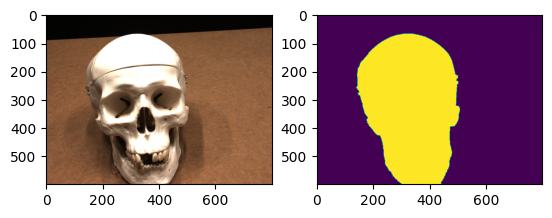

In [5]:
from exercise_3.data.dtu import DTUTrainDataset, DTUValDataset

num_rays = 128
train_dataset = DTUTrainDataset(num_rays)
val_dataset = DTUValDataset()
print(f"Training has {len(train_dataset)} images, and validation has {len(val_dataset)} images")

rays_o, rays_d, rgb, mask = train_dataset[0]
print("The shape of the train_dataset output", rays_o.shape, rays_d.shape, rgb.shape, mask.shape)

rays_o, rays_d, rgb, mask = val_dataset[0]
print("The shape of the val_dataset output", rays_o.shape, rays_d.shape, rgb.shape, mask.shape)

# Visualize the image and mask from the val set
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.subplot(1, 2, 2)
plt.imshow(mask)

### (c) Model, Renderer, and Evaluation

You are asked to implement the network in `exercise_3/model/neus.py`. The model architecture of NeuS is visualized below.

<img src="exercise_3/images/neus_arch.png" alt="neus_arch" style="width: 640px;"/>

**Positional encoding** encodes three dimension vector (e.g., x, y, z) into higher dimension and higher frequency vector, which helps the MLP network to learn sharp details. The definitation is as follows:
$$
f(X_i) = [X_i, sin(2^0 X_i), cos(2^0 X_i), sin(2^1 X_i), cos(2^1 X_i), ..., sin(2^N X_i), cos(2^N X_i)]
$$
where $N$ is the number of frequency in total and $(X_0, X_1, X_2) = (x, y, z)$ in our case.

**Things to note**:
* The output of the SDF field network is (1 + latent_size). The first output is the SDF value, and the rest are the latent vector, which is going to be part of the input of the color fields.
* There is a skip connection in the SDF field network. It's usually helpful to have skip connection for deep MLP.
* The color field output will need to go through a sigmoid function to map output values into [0, 1]


In [6]:
from exercise_3.model.neus import SDFField, ColorField
from exercise_3.util.model import summarize_model

sdf_field = SDFField()
color_field = ColorField()
print("==== SDF field summary ====")
print(summarize_model(sdf_field))

print("==== Color field summary ====")
print(summarize_model(color_field))

x = torch.rand(10, 3)
out = sdf_field(x)
print(f"input shape: {x.shape}. output shape: {out.shape}")

==== SDF field summary ====
   | Name          | Type                | Params
-------------------------------------------------------
0  | activation    | Softplus            | 0     
1  | embed_fn      | PositionalEmbedding | 0     
2  | first_part    | Sequential          | 33113 
3  | first_part.0  | Linear              | 5120  
4  | first_part.2  | Linear              | 16512 
5  | first_part.4  | Linear              | 11481 
6  | second_part   | Sequential          | 66177 
7  | second_part.0 | Linear              | 16512 
8  | second_part.2 | Linear              | 16512 
9  | second_part.4 | Linear              | 16512 
10 | second_part.6 | Linear              | 16641 
11 | TOTAL         | SDFField            | 99290 
==== Color field summary ====
  | Name       | Type                | Params
---------------------------------------------------
0 | activation | ReLU                | 0     
1 | embed_fn   | PositionalEmbedding | 0     
2 | network    | Sequential          | 70659 


You are asked to implement on part of the **volumetric rendering** and the **eikonal loss** in `exercise_3/model/renderer.py`.

The volumetric rendering in NeuS integrate the SDF values and color on a ray into a single color. The paper contains thorough math and theorems that are very interesting. For simplicity, we only need to implement the last and easy part. Assuming we have single-channel images (e.g., gray-scale image), the rendering equation (Eq 11. in NeuS paper) looks like the following:
$$
w_i = \alpha_i \prod_{j=0}^{j<i} (1- \alpha_j),
$$
$$
c = \sum_{i \in N} c_i w_i,
$$
where $N$ is the number of samples along the ray, $c_i$ is the color of the sampe (outputed by the color field), $alpha_i$ is the opacity of the sampled (which is already converted from the SDF values), $c$ is the color of the pixel.


The eikonal loss make sure the SDF field follows the geometry propery of SDF: the magnitude of the gradient of the SDF should be 1 almost everywhere, which means that the changes of SDF value should be a constant in when moving in the 3D coordinate system. For example, if we check the SDF value of one location (x, y, z) and its neighboring location (x + 1, y, z), the SDF absolute difference should be 1, and likewse, the absolute SDF difference between (x, y, z) and (x, y + 0.5, z) is 0.5.

It is a key regularization loss for learning SDF field. The loss definition is relatively simple as follow:
$$
\frac{1}{N} \sum_i (||\nabla f(p_i) ||_2 - 1)^2
$$

The part of this subsection is to implement the evaluation metric. To measure how similiar are two images (e.g., the recontructed RGB image and the ground-truth RGB), we commonly use [Peak signal-to-noise ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio).
$$
PSNR = 10 \log_{10} (1 / MSE)
$$
where

$$
MSE = \frac{1}{3 H W} \sum_u^W \sum_v^H \sum_c^3 [I_c(u, v) - K_c(u, v)]^2
$$

In our case, we also have to ignore those pixels in the background defined by the mask:

$$
MSE = \frac{1}{3 |\text{valid pixels}|}\sum_{(u, v) \in \text{valid pixels}}\sum_c^3 [I_c(u, v) - K_c(u, v)]^2
$$

Please implement `compute_psnr` in `exercise_3/model/neus.py`.

PSNR=21.051671981811523


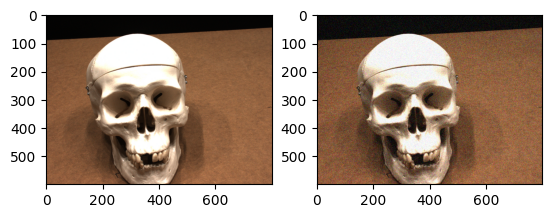

In [7]:
from exercise_3.model.neus import compute_psnr

rays_o, rays_d, rgb, mask = val_dataset[0]
# Add gaussian noises
random_noise = torch.randn_like(rgb) * 0.1
rgb_with_noise = (rgb + random_noise).clamp(0, 1)

psnr = compute_psnr(rgb, rgb_with_noise, mask)
print(f"PSNR={psnr}")
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.subplot(1, 2, 2)
plt.imshow(rgb_with_noise)

##### (d) Training
In this step, the training code are ready to run. Ideally, the training might takes 2-3 hours, and you should able to get validation PSNR > 23 at the end.


In [8]:
from exercise_3.training.train_neus import main

config = {
    'experiment_name': '3_2_neus',
    'device': 'cuda:0',
    'num_rays_per_image': 256,
    'num_image_per_batch': 4,
    'num_samples_init': 64,
    'num_samples_importance': 64,
    'eikonal_weight': 0.1,
    'mask_weight': 0.1,
    'learning_rate_model': 5e-4,
    'max_epochs': 2000,
    'print_every_n': 50,
    'validate_every_n': 1000,
    'save_every_n': 1000,
    'resume_ckpt': None,
}

main(config)

Using device: cuda:0
Train dataset size: 45. Val dataset size: 4
[004/000049] train_loss: 1.311768 train_psnr: 9.916693
[008/000099] train_loss: 1.157727 train_psnr: 10.990974
[012/000149] train_loss: 0.961144 train_psnr: 12.255907
[016/000199] train_loss: 0.608597 train_psnr: 12.856346
[020/000249] train_loss: 0.510772 train_psnr: 13.671223
[024/000299] train_loss: 0.472034 train_psnr: 13.899963
[029/000349] train_loss: 0.444316 train_psnr: 14.288752
[033/000399] train_loss: 0.437592 train_psnr: 14.436835
[037/000449] train_loss: 0.381264 train_psnr: 15.455361
[041/000499] train_loss: 0.347061 train_psnr: 16.121810
[045/000549] train_loss: 0.315375 train_psnr: 16.876131
[049/000599] train_loss: 0.302903 train_psnr: 17.159608
[054/000649] train_loss: 0.289042 train_psnr: 17.410225
[058/000699] train_loss: 0.280674 train_psnr: 17.775045
[062/000749] train_loss: 0.249747 train_psnr: 18.586769
[066/000799] train_loss: 0.249193 train_psnr: 18.488646
[070/000849] train_loss: 0.247114 train_

In [12]:
os.listdir('exercise_3/runs/3_2_neus')

['0001.png',
 'model.ckpt',
 '0000.png',
 'model_best.ckpt',
 '0002.png',
 'mesh.ply',
 '0003.png']

In [13]:
!cp -r exercise_3/runs /content/drive/My\ Drive/runs

### (E) Inference
The inference code has already been combined into the training code. There are two part of it:
- `reconstruct_mesh`: Recontruct the mesh from the SDF field
- `validate_images`: Render novel-view images in the validation set (the images are not seen during training). If you are running out of memory during this stage, you can try reduce the `batch_size` parameter in `validate_images` function. It controls how many pixels are you rendering once.

In [14]:
from exercise_3.util.visualization import visualize_mesh

mesh = trimesh.load("exercise_3/runs/3_2_neus/mesh.ply")
print(mesh.vertices.shape, mesh.faces.shape)
visualize_mesh(mesh.vertices, mesh.faces)

(54801, 3) (109712, 3)


/usr/local/lib/python3.10/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

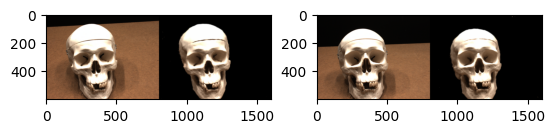

In [15]:
novel_image1 = np.asarray(Image.open("exercise_3/runs/3_2_neus/0000.png"))
plt.subplot(1, 2, 1)
plt.imshow(novel_image1)
novel_image2 = np.asarray(Image.open("exercise_3/runs/3_2_neus/0001.png"))
plt.subplot(1, 2, 2)
plt.imshow(novel_image2)

## Submission

This is the end of exercise 3 🙂. Please create a zip containing all files we provided, everything you modified, your visualization images/gif (no need to submit generated OBJs), including your checkpoints. Name it with your matriculation number(s) as described in exercise 1. Make sure this notebook can be run without problems. Then, submit via Moodle.

**Note**: The maximum submission file size limit for Moodle is 100M. You do not need to submit your overfitting checkpoints; however, the generalization checkpoint will be >200M. The easiest way to still be able to submit that one is to split it with zip like this: `zip -s 100M model_best.ckpt.zip model_best.ckpt` which creates a `.zip` and a `.z01`. You can then submit both files alongside another zip containing all your code and outputs.

**Submission Deadline**: 18.12.2024, 23:55

## References

[1] Park, Jeong Joon, et al. "Deepsdf: Learning continuous signed distance functions for shape representation." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.

[2] Wang, Peng, et al. "Neus: Learning neural implicit surfaces by volume rendering for multi-view reconstruction." NeurIPS 2021.